# Asset-class tickers used in this notebook

- **Sweden**: EWD — iShares MSCI Sweden ETF (Swedish equities)
- **USA**: SPY — SPDR S&P 500 ETF Trust (US large-cap / S&P 500)
- **Emerging**: VWO — Vanguard FTSE Emerging Markets ETF (emerging markets equities)
- **Gold**: GLD — SPDR Gold Shares (gold bullion proxy)
- **Bonds**: BND — Vanguard Total Bond Market ETF (broad US bond market)
- **REITs**: VNQ — Vanguard Real Estate ETF (US real estate / REITs)

These ETF tickers are used as asset-class proxies and appear in `DEFAULT_TICKERS_EXT`.

In [13]:
# Define the asset-class tickers we will use (overrides internal defaults)
# ETF proxies: Sweden, USA, Emerging, Gold, Bonds, REITs
DEFAULT_TICKERS_EXT = {"Sweden": "EWD", "USA": "SPY", "Emerging": "VWO", "Gold": "GLD", "Bonds": "BND", "REITs": "VNQ"}
DEFAULT_TICKERS_EXT

{'Sweden': 'EWD',
 'USA': 'SPY',
 'Emerging': 'VWO',
 'Gold': 'GLD',
 'Bonds': 'BND',
 'REITs': 'VNQ'}

In [14]:
# Helper functions defined inline so the notebook is self-contained
from typing import Dict, Optional
import pandas as pd
import numpy as np
import yfinance as yf

DEFAULT_TICKERS = {"Sweden": "EWD", "USA": "SPY", "Emerging": "VWO"}
TRADING_DAYS = 252

def fetch_prices(tickers: Dict[str, str], start: str, end: Optional[str] = None) -> pd.DataFrame:
    yf_tickers = list(tickers.values())
    data = yf.download(yf_tickers, start=start, end=end, progress=False, auto_adjust=False)
    if data.empty:
        raise RuntimeError("No data fetched. Check tickers or date range.")
    adj = data["Adj Close"].copy()
    if isinstance(adj, pd.Series):
        adj = adj.to_frame(adj.name)
    mapping = {tickers[k]: k for k in tickers}
    adj = adj.rename(columns=mapping)
    adj = adj.sort_index()
    return adj

def compute_returns(prices: pd.DataFrame, method: str = "log") -> pd.DataFrame:
    if method == "log":
        return np.log(prices / prices.shift(1)).dropna()
    else:
        return prices.pct_change().dropna()

def apply_annual_fees(returns: pd.DataFrame, annual_fees: Dict[str, float]) -> pd.DataFrame:
    daily_fees = {k: (1 + v) ** (1 / TRADING_DAYS) - 1 for k, v in annual_fees.items()}
    net = returns.copy()
    for col in net.columns:
        fee = daily_fees.get(col, 0.0)
        net[col] = net[col] - fee
    return net

def apply_isk_simple_tax_on_annual(values: pd.Series, annual_tax_rate: float) -> pd.Series:
    vals = values.copy()
    yrs = vals.index.year
    year_ends = vals.groupby(yrs).apply(lambda s: s.index[-1])
    for idx in year_ends:
        tax_base = vals.loc[idx]
        vals.loc[idx:] = vals.loc[idx:] - (annual_tax_rate * tax_base)
    return vals

def portfolio_return_series(returns: pd.DataFrame, weights: Dict[str, float]) -> pd.Series:
    cols = list(weights.keys())
    w = np.array([weights[c] for c in cols])
    rets = returns[cols].dot(w)
    return rets

def cagr_from_value_series(values: pd.Series) -> float:
    days = (values.index[-1] - values.index[0]).days
    years = days / 365.25
    return (values.iloc[-1] / values.iloc[0]) ** (1 / years) - 1

def max_drawdown(values: pd.Series) -> float:
    cum = values / values.iloc[0]
    roll_max = cum.cummax()
    dd = (cum / roll_max) - 1
    return dd.min()

def annualized_vol(returns: pd.Series) -> float:
    return returns.std() * np.sqrt(TRADING_DAYS)

def sharpe_ratio(returns: pd.Series, risk_free: float = 0.0) -> float:
    ann_ret = returns.mean() * TRADING_DAYS
    ann_vol = annualized_vol(returns)
    return (ann_ret - risk_free) / ann_vol if ann_vol != 0 else np.nan

def portfolio_metrics_from_returns(portfolio_rets: pd.Series, start_value: float = 1.0, risk_free: float = 0.0) -> Dict[str, float]:
    values = (1 + portfolio_rets).cumprod() * start_value
    return {
        "CAGR": cagr_from_value_series(values),
        "AnnualVol": annualized_vol(portfolio_rets),
        "Sharpe": sharpe_ratio(portfolio_rets, risk_free),
        "MaxDrawdown": max_drawdown(values)
    }

In [15]:
# Fetch prices and show head
# Use the extended ticker mapping defined above
tickers = DEFAULT_TICKERS_EXT
prices = fetch_prices(tickers, start="2007-04-10")
prices.head()

Ticker,Bonds,Sweden,Gold,USA,REITs,Emerging
Date,,,,,,
2007-04-10,41.903645,18.515081,67.160004,102.076187,36.736988,24.251347
2007-04-11,41.792274,18.321556,67.080002,101.659691,36.189678,24.183311
2007-04-12,41.786678,18.577841,66.989998,102.111496,35.943390,24.491003
2007-04-13,41.719856,18.687670,67.839996,102.577301,36.349297,24.570879
2007-04-16,41.758831,19.095633,68.400002,103.551453,36.394909,24.878569


In [16]:
# Compute returns, apply fees and compute portfolio metrics
returns = compute_returns(prices, method="simple")
# Example annual fees (expense ratios) for the ETF proxies
fees = {"Sweden": 0.0025, "USA": 0.0009, "Emerging": 0.003, "Gold": 0.004, "Bonds": 0.00035, "REITs": 0.0012}
net_returns = apply_annual_fees(returns, fees)
# Example weights (must match keys in DEFAULT_TICKERS_EXT)
weights = {"Sweden": 0.15, "USA": 0.5, "Emerging": 0.1, "Gold": 0.1, "Bonds": 0.1, "REITs": 0.05}
port_rets = portfolio_return_series(net_returns, weights)
metrics = portfolio_metrics_from_returns(port_rets)
metrics

{'CAGR': 0.08976490692374539,
 'AnnualVol': 0.17517789738423603,
 'Sharpe': 0.5775096821997475,
 'MaxDrawdown': -0.4785664432324992}

In [17]:
# Portfolio explorer: generate random portfolios and evaluate metrics
import numpy as np
import pandas as pd


def generate_random_portfolios(returns: pd.DataFrame, num_portfolios: int = 2000, seed: int = 42) -> pd.DataFrame:
    """Generate random weight combinations (Dirichlet), evaluate portfolio metrics over full period.
    Returns a DataFrame with one row per portfolio and columns for metrics + weights.
    """
    np.random.seed(seed)
    assets = list(returns.columns)
    n = len(assets)
    samples = np.random.dirichlet(np.ones(n), size=num_portfolios)

    rows = []
    for s in samples:
        w = {asset: float(s[i]) for i, asset in enumerate(assets)}
        port_rets = portfolio_return_series(returns, w)
        mets = portfolio_metrics_from_returns(port_rets)
        row = {"CAGR": mets["CAGR"], "AnnualVol": mets["AnnualVol"], "Sharpe": mets["Sharpe"], "MaxDrawdown": mets["MaxDrawdown"]}
        # add weights
        for i, asset in enumerate(assets):
            row[f"w_{asset}"] = s[i]
        rows.append(row)

    df = pd.DataFrame(rows)
    # optional: compute annual return for quick reference
    df["Return"] = df["CAGR"]
    return df

# Example: generate 2000 candidate portfolios and show top 10 by Sharpe
candidates = generate_random_portfolios(net_returns, num_portfolios=2000)
candidates.sort_values("Sharpe", ascending=False).head(10)

,CAGR,AnnualVol,Sharpe,MaxDrawdown,w_Bonds,w_Sweden,w_Gold,w_USA,w_REITs,w_Emerging,Return
1708,0.054379,0.064825,0.848229,-0.173195,0.667028,0.003235,0.193202,0.046915,0.006650,0.082970,0.054379
732,0.095610,0.116540,0.841459,-0.281359,0.165154,0.007429,0.464648,0.293958,0.056022,0.012790,0.095610
1158,0.072415,0.087993,0.837207,-0.220683,0.446099,0.004235,0.291097,0.133755,0.123330,0.001484,0.072415
526,0.067701,0.082469,0.834270,-0.187078,0.499163,0.011992,0.315732,0.062703,0.106394,0.004017,0.067701
1403,0.069632,0.085218,0.831177,-0.213392,0.476108,0.054054,0.282401,0.097399,0.086179,0.003860,0.069632
1628,0.058703,0.071629,0.831019,-0.180068,0.603534,0.028118,0.205274,0.058464,0.027293,0.077317,0.058703
1367,0.062101,0.076117,0.828180,-0.188125,0.573529,0.098281,0.226369,0.061110,0.028192,0.012517,0.062101
1429,0.065933,0.081903,0.819133,-0.193810,0.512157,0.018793,0.293737,0.049233,0.109598,0.016482,0.065933
85,0.096583,0.121687,0.818163,-0.301562,0.151471,0.086334,0.430156,0.320406,0.007375,0.004259,0.096583
1445,0.054373,0.067550,0.816282,-0.182796,0.657576,0.032671,0.153948,0.053896,0.013854,0.088056,0.054373


Portfolios with CAGR>8%: 643


,CAGR,AnnualVol,Sharpe,MaxDrawdown,w_Bonds,w_Sweden,w_Gold,w_USA,w_REITs,w_Emerging
0,0.095610,0.116540,0.841459,-0.281359,0.165154,0.007429,0.464648,0.293958,0.056022,0.012790
1,0.096583,0.121687,0.818163,-0.301562,0.151471,0.086334,0.430156,0.320406,0.007375,0.004259
2,0.096152,0.121875,0.813938,-0.319232,0.162975,0.014061,0.340943,0.418188,0.010390,0.053442


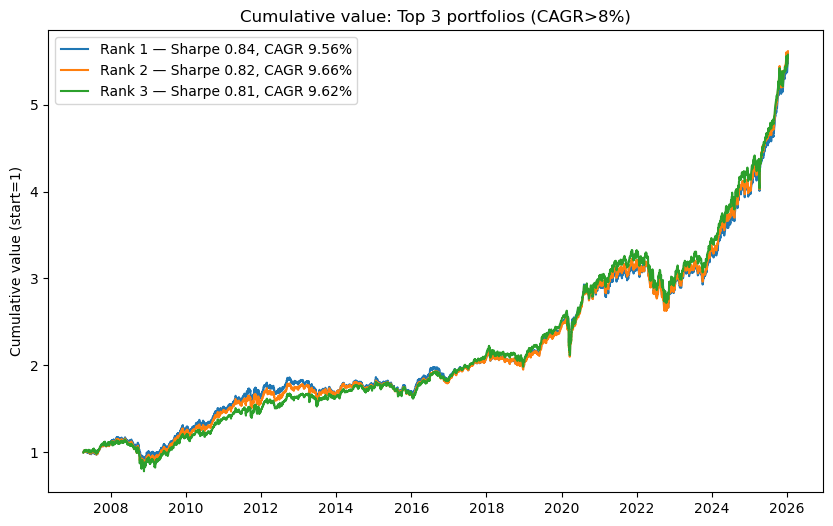

C:\Users\maxth\AppData\Local\Temp\ipykernel_43208\977381539.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(assets, rotation=45, ha='right')


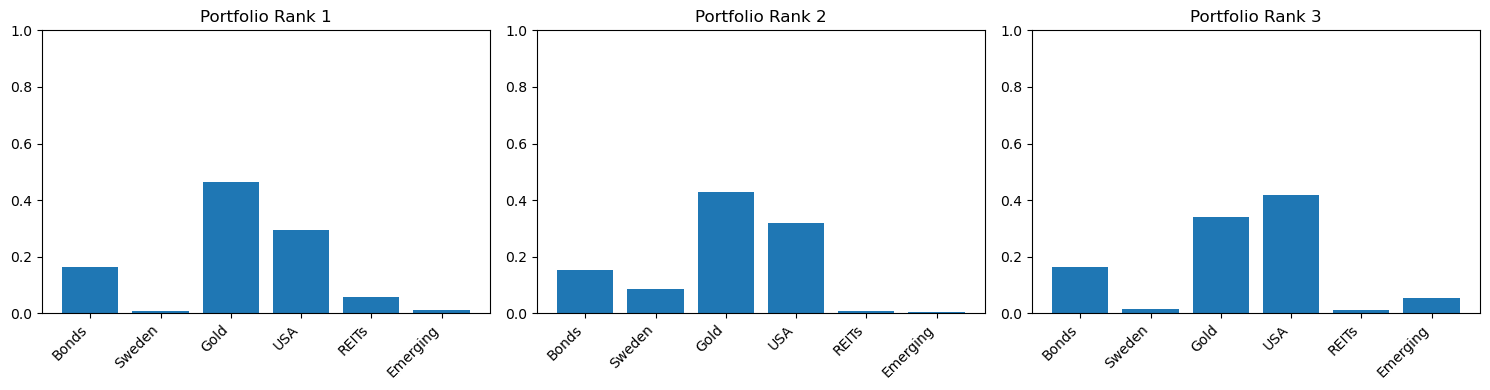

In [20]:
# Filter portfolios (CAGR > 8%) and visualize top 3 by Sharpe
import matplotlib.pyplot as plt

# Filter
filtered = candidates[candidates['CAGR'] > 0.08].copy()
filtered = filtered.sort_values('Sharpe', ascending=False)
print(f"Portfolios with CAGR>8%: {len(filtered)}")
if len(filtered) == 0:
    print("No portfolios meet the CAGR>8% threshold.")
else:
    top3 = filtered.head(3).reset_index(drop=True)
    display_cols = ['CAGR', 'AnnualVol', 'Sharpe', 'MaxDrawdown'] + [c for c in top3.columns if c.startswith('w_')]
    display(top3[display_cols])

    # cumulative returns plot for top 3
    assets = list(net_returns.columns)
    plt.figure(figsize=(10,6))
    for i, row in top3.iterrows():
        weights = {asset: float(row[f'w_{asset}']) for asset in assets}
        p_rets = portfolio_return_series(net_returns, weights)
        vals = (1 + p_rets).cumprod()
        plt.plot(vals.index, vals, label=f"Rank {i+1} — Sharpe {row['Sharpe']:.2f}, CAGR {row['CAGR']:.2%}")
    plt.legend()
    plt.title('Cumulative value: Top 3 portfolios (CAGR>8%)')
    plt.ylabel('Cumulative value (start=1)')
    plt.show()

    # weight bar charts
    fig, axes = plt.subplots(1, min(3, len(top3)), figsize=(15,4))
    if min(3, len(top3)) == 1:
        axes = [axes]
    for i, row in top3.iterrows():
        w = [float(row[f'w_{asset}']) for asset in assets]
        ax = axes[i]
        ax.bar(assets, w)
        ax.set_title(f"Portfolio Rank {i+1}")
        ax.set_ylim(0,1)
        ax.set_xticklabels(assets, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Takeaway -> High Gold and High US and around 15-20% Bonds seems to create a good return/risk profile.

In [19]:
# ISK tax example (simple annual tax at year-end)
start_value = 1.0
values = (1 + port_rets).cumprod() * start_value
tax_rate = 0.003  # example 0.3% annual schablon
values_after_tax = apply_isk_simple_tax_on_annual(values, tax_rate)
print('CAGR before tax:', cagr_from_value_series(values))
print('CAGR after tax:', cagr_from_value_series(values_after_tax))

CAGR before tax: 0.08976490692374539
CAGR after tax: 0.08817653209529763


**Next steps**: add plotting, implement a proper ISK schablon calculation using the official formula (government rate + 1%), and add an optimizer to maximize Sharpe under constraints.